This is the training companion notebook to the inference notebook I have published here:


## Dependencies

In [1]:
# %pip install --quiet /kaggle/input/timm_3d_deps/other/initial/10/pydicom/pydicom/pydicom-2.4.4-py3-none-any.whl
# %pip install timm_3d --no-index --quiet --find-links=/kaggle/input/timm_3d_deps/other/initial/10/timm_3d/
# %pip install torchio --no-index --quiet --find-links=/kaggle/input/timm_3d_deps/other/initial/10/torchio/
# %pip install itk --no-index --quiet --find-links=/kaggle/input/timm_3d_deps/other/initial/10/itk/itk
# %pip install skorch --no-index --quiet --find-links=/kaggle/input/timm_3d_deps/other/initial/10/skorch/skorch
# %pip install spacecutter --no-index --quiet --find-links=/kaggle/input/timm_3d_deps/other/initial/10/spacecutter/
# %pip install open3d --no-index --quiet --find-links=/kaggle/input/timm_3d_deps/other/initial/10/open3d
# %pip install pgzip --no-index --quiet --find-links=/kaggle/input/timm_3d_deps/other/initial/10/pgzip

## Config

In [2]:
data_path = "/home/ai/neo/data/rsna-2024-lumbar-spine-degenerative-classification/"

In [3]:
import torch

CONFIG = dict(
    n_levels=5,
    num_classes=25,
    num_conditions=5,
    image_interpolation="nearest",
    backbone="maxvit_rmlp_tiny_rw_256",
    # backbone="efficientnet_b0",
    vol_size=(256, 256, 256),
    # vol_size=(64, 64, 64),
    num_workers=8,
    gradient_acc_steps=1,
    drop_rate=0.4,
    drop_rate_last=0.,
    drop_path_rate=0.4,
    aug_prob=0.9,
    out_dim=3,
    epochs=100,
    # epochs=5,
    batch_size=16,
    split_k=5,
    device=torch.device("cuda") if torch.cuda.is_available() else "cpu",
    seed=42
)

In [4]:
CONDITIONS = {
    "Sagittal T2/STIR": ["Spinal Canal Stenosis"],
    "Axial T2": ["Left Subarticular Stenosis", "Right Subarticular Stenosis"],
    "Sagittal T1": ["Left Neural Foraminal Narrowing", "Right Neural Foraminal Narrowing"],
}
LABEL_MAP = {'normal_mild': 0, 'moderate': 1, 'severe': 2}

# Data Loading

## Training Metadata

In [5]:
def retrieve_coordinate_training_data(train_path):
    def reshape_row(row):
        data = {'study_id': [], 'condition': [], 'level': [], 'severity': []}

        for column, value in row.items():
            if column not in ['study_id', 'series_id', 'instance_number', 'x', 'y', 'series_description']:
                parts = column.split('_')
                condition = ' '.join([word.capitalize() for word in parts[:-2]])
                level = parts[-2].capitalize() + '/' + parts[-1].capitalize()
                data['study_id'].append(row['study_id'])
                data['condition'].append(condition)
                data['level'].append(level)
                data['severity'].append(value)

        return pd.DataFrame(data)

    train = pd.read_csv(train_path + 'train.csv')
    label = pd.read_csv(train_path + 'train_label_coordinates.csv')
    train_desc = pd.read_csv(train_path + 'train_series_descriptions.csv')
    test_desc = pd.read_csv(train_path + 'test_series_descriptions.csv')
    sub = pd.read_csv(train_path + 'sample_submission.csv')

    new_train_df = pd.concat([reshape_row(row) for _, row in train.iterrows()], ignore_index=True)
    merged_df = pd.merge(new_train_df, label, on=['study_id', 'condition', 'level'], how='inner')
    final_merged_df = pd.merge(merged_df, train_desc, on=['series_id', 'study_id'], how='inner')
    final_merged_df['severity'] = final_merged_df['severity'].map(
        {'Normal/Mild': 'normal_mild', 'Moderate': 'moderate', 'Severe': 'severe'})

    final_merged_df['row_id'] = (
            final_merged_df['study_id'].astype(str) + '_' +
            final_merged_df['condition'].str.lower().str.replace(' ', '_') + '_' +
            final_merged_df['level'].str.lower().str.replace('/', '_')
    )

    # Create the image_path column
    final_merged_df['image_path'] = (
            f'{train_path}/train_images/' +
            final_merged_df['study_id'].astype(str) + '/' +
            final_merged_df['series_id'].astype(str) + '/' +
            final_merged_df['instance_number'].astype(str) + '.dcm'
    )

    return final_merged_df

In [6]:
import pandas as pd

train_data = retrieve_coordinate_training_data(data_path)

## Dataset Definitions

Note the mirror trick -- by flipping across the X axis, we get any right labels as left also and vice versa

In [7]:
from torch.utils.data import Dataset, DataLoader


class StudyLevelDataset(Dataset):
    def __init__(self,
                 base_path: str,
                 dataframe: pd.DataFrame,
                 transform_3d=None,
                 is_train=False,
                 vol_size=(192, 192, 192),
                 use_mirror_trick=False):
        self.base_path = base_path
        self.is_train = is_train
        self.use_mirror_trick = use_mirror_trick

        self.dataframe = (dataframe[['study_id', "series_id", "series_description", "condition", "severity", "level"]]
                          .drop_duplicates())

        self.subjects = self.dataframe[['study_id']].drop_duplicates().reset_index(drop=True)
        self.series = self.dataframe[["study_id", "series_id"]].drop_duplicates().groupby("study_id")[
            "series_id"].apply(list).to_dict()
        self.series_descs = {e[0]: e[1] for e in
                             self.dataframe[["series_id", "series_description"]].drop_duplicates().values}

        self.transform_3d = transform_3d

        self.levels = sorted(self.dataframe["level"].unique())
        self.labels = self._get_labels()
        self.vol_size = vol_size

    def __len__(self):
        return len(self.subjects) * (2 if self.use_mirror_trick else 1)

    def __getitem__(self, index):
        is_mirror = index >= len(self.subjects)
        curr = self.subjects.iloc[index % len(self.subjects)]

        label = np.array(self.labels[(curr["study_id"])])
        study_path = os.path.join(self.base_path, str(curr["study_id"]))

        study_images = read_study_as_voxel_grid_v2(study_path,
                                                   curr["study_id"],
                                                   series_type_dict=self.series_descs,
                                                   img_size=(self.vol_size[0], self.vol_size[1]))

        if is_mirror:
            temp = label[:10].copy()
            label[:10] = label[10:20].copy()
            label[10:20] = temp

        if self.transform_3d is not None:
            study_images = torch.FloatTensor(study_images)

            if is_mirror:
                study_images = torch.flip(study_images, [1])

            study_images = self.transform_3d(study_images)  # .data
            return study_images.to(torch.half), torch.tensor(label, dtype=torch.long)

        print("loaded")
        return torch.HalfTensor(study_images.copy()), torch.tensor(label, dtype=torch.long)

    def _get_labels(self):
        labels = dict()
        for name, group in self.dataframe.groupby(["study_id"]):
            group = group[["condition", "level", "severity"]].drop_duplicates().sort_values(["condition", "level"])
            label_indices = []
            for index, row in group.iterrows():
                if row["severity"] in LABEL_MAP:
                    label_indices.append(LABEL_MAP[row["severity"]])
                else:
                    raise ValueError()

            study_id = name[0]

            labels[study_id] = label_indices

        return labels

## 3D Data Loading

Explained in a little more detail on my inference notebook. Note the caching part -- this makes a huge difference in the training time since the transforms are a massive bottleneck otherwise

In [8]:
def read_study_as_voxel_grid_v2(dir_path,
                                study_id,
                                series_type_dict=None, 
                                downsampling_factor=1, 
                                img_size=(256, 256), 
                                caching=True,
                                cache_base_path="/home/ai/neo/data/cache"):
    if caching:
        os.makedirs(os.path.join(cache_base_path, str(study_id)), exist_ok=True)
        cache_path = os.path.join(cache_base_path, str(study_id), f"cached_grid_v2_{img_size[0]}.npy.gz")
        f = None
        if os.path.exists(cache_path):
            try:
                f = pgzip.PgzipFile(cache_path, "r")
                ret = np.load(f, allow_pickle=True)
                f.close()
                return ret
            except Exception as e:
                print(dir_path, "\n", e)
                if f:
                    f.close()
                os.remove(cache_path)

    pcd_overall = read_study_as_pcd(dir_path,
                                    series_types_dict=series_type_dict,
                                    downsampling_factor=downsampling_factor,
                                    img_size=img_size)
    box = pcd_overall.get_axis_aligned_bounding_box()

    max_b = np.array(box.get_max_bound())
    min_b = np.array(box.get_min_bound())

    pts = (np.array(pcd_overall.points) - (min_b)) * (
            (img_size[0] - 1, img_size[0] - 1, img_size[0] - 1) / (max_b - min_b))
    coords = np.round(pts).astype(np.int32)
    vals = np.array(pcd_overall.colors, dtype=np.float16)

    grid = np.zeros((3, img_size[0], img_size[0], img_size[0]), dtype=np.float16)
    indices = coords[:, 0], coords[:, 1], coords[:, 2]

    np.maximum.at(grid[0], indices, vals[:, 0])
    np.maximum.at(grid[1], indices, vals[:, 1])
    np.maximum.at(grid[2], indices, vals[:, 2])
    
    if caching:
        f = pgzip.PgzipFile(cache_path, "w")
        np.save(f, grid)
        f.close()

    return grid


def read_study_as_pcd(dir_path,
                      series_types_dict=None,
                      downsampling_factor=1,
                      resize_slices=True,
                      resize_method="nearest",
                      stack_slices_thickness=True,
                      img_size=(256, 256)):
    pcd_overall = o3d.geometry.PointCloud()

    for path in glob.glob(os.path.join(dir_path, "**/*.dcm"), recursive=True):
        dicom_slice = dcmread(path)

        series_id = os.path.basename(os.path.dirname(path))
        study_id = os.path.basename(os.path.dirname(os.path.dirname(path)))
        if series_types_dict is None or int(series_id) not in series_types_dict:
            series_desc = dicom_slice.SeriesDescription
        else:
            series_desc = series_types_dict[int(series_id)]
            series_desc = series_desc.split(" ")[-1]

        x_orig, y_orig = dicom_slice.pixel_array.shape
        if resize_slices:
            if resize_method == "nearest":
                img = np.expand_dims(cv2.resize(dicom_slice.pixel_array, img_size, interpolation=cv2.INTER_AREA), -1)
            elif resize_method == "maxpool":
                img_tensor = torch.tensor(dicom_slice.pixel_array).float()
                img = F.adaptive_max_pool2d(img_tensor.unsqueeze(0), img_size).numpy()
            else:
                raise ValueError(f"Invalid resize_method {resize_method}")
        else:
            img = np.expand_dims(np.array(dicom_slice.pixel_array), -1)
        x, y, z = np.where(img)

        downsampling_factor_iter = max(downsampling_factor, int(math.ceil(len(x) / 6e6)))

        index_voxel = np.vstack((x, y, z))[:, ::downsampling_factor_iter]
        grid_index_array = index_voxel.T
        pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(grid_index_array.astype(np.float64)))

        vals = np.expand_dims(img[x, y, z][::downsampling_factor_iter], -1)
        if series_desc == "T1":
            vals = np.pad(vals, ((0, 0), (0, 2)))
        elif series_desc == "T2":
            vals = np.pad(vals, ((0, 0), (1, 1)))
        elif series_desc == "T2/STIR":
            vals = np.pad(vals, ((0, 0), (2, 0)))
        else:
            raise ValueError(f"Unknown series desc: {series_desc}")

        pcd.colors = o3d.utility.Vector3dVector(vals.astype(np.float64))

        if resize_slices:
            transform_matrix_factor = np.matrix(
                [[0, y_orig / img_size[1], 0, 0],
                 [x_orig / img_size[0], 0, 0, 0],
                 [0, 0, 1, 0],
                 [0, 0, 0, 1]]
            )
        else:
            transform_matrix_factor = np.matrix(
                [[0, 1, 0, 0],
                 [1, 0, 0, 0],
                 [0, 0, 1, 0],
                 [0, 0, 0, 1]]
            )

        dX, dY = dicom_slice.PixelSpacing
        dZ = dicom_slice.SliceThickness

        X = np.array(list(dicom_slice.ImageOrientationPatient[:3]) + [0]) * dX
        Y = np.array(list(dicom_slice.ImageOrientationPatient[3:]) + [0]) * dY

        S = np.array(list(dicom_slice.ImagePositionPatient) + [1])

        transform_matrix = np.array([X, Y, np.zeros(len(X)), S]).T
        transform_matrix = transform_matrix @ transform_matrix_factor

        if stack_slices_thickness:
            for z in range(int(dZ)):
                pos = list(dicom_slice.ImagePositionPatient)
                if series_desc == "T2":
                    pos[-1] += z
                else:
                    pos[0] += z
                S = np.array(pos + [1])

                transform_matrix = np.array([X, Y, np.zeros(len(X)), S]).T
                transform_matrix = transform_matrix @ transform_matrix_factor

                pcd_overall += copy.deepcopy(pcd).transform(transform_matrix)

        else:
            pcd_overall += copy.deepcopy(pcd).transform(transform_matrix)

    return pcd_overall

## Dataset Utility

See the cleaning here -- I am simply dropping the data points where any of the 25 labels are missing

In [9]:
def create_study_level_datasets_and_loaders_k_fold(df: pd.DataFrame,
                                                   base_path: str,
                                                   transform_3d_train=None,
                                                   transform_3d_val=None,
                                                   vol_size=None,
                                                   split_k=5,
                                                   random_seed=42,
                                                   batch_size=1,
                                                   num_workers=0,
                                                   pin_memory=True,
                                                   use_mirroring_trick=True):
    df = df.dropna()
    # This drops any subjects with nans

    filtered_df = pd.DataFrame(columns=df.columns)
    for series_desc in CONDITIONS.keys():
        subset = df[df['series_description'] == series_desc]
        if series_desc == "Sagittal T2/STIR":
            subset = subset[subset.groupby(["study_id"]).transform('size') == 5]
        else:
            subset = subset[subset.groupby(["study_id"]).transform('size') == 10]
        filtered_df = pd.concat([filtered_df, subset])

    filtered_df = filtered_df[filtered_df.groupby(["study_id"]).transform('size') == 25]

    np.random.seed(random_seed)
    ids = filtered_df["study_id"].unique()
    np.random.shuffle(ids)

    ret = []
    folds = np.array_split(ids, split_k)

    for index, fold in enumerate(folds):
        val_studies = fold

        train_df = filtered_df[~filtered_df["study_id"].isin(val_studies)]
        val_df = filtered_df[filtered_df["study_id"].isin(val_studies)]

        train_df = train_df.reset_index(drop=True)
        val_df = val_df.reset_index(drop=True)

        train_dataset = StudyLevelDataset(base_path, train_df,
                                          transform_3d=transform_3d_train,
                                          is_train=True,
                                          use_mirror_trick=use_mirroring_trick,
                                          vol_size=vol_size
                                          )
        val_dataset = StudyLevelDataset(base_path, val_df,
                                        transform_3d=transform_3d_val,
                                        vol_size=vol_size
                                        )

        train_loader = DataLoader(train_dataset,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  num_workers=num_workers,
                                  pin_memory=pin_memory,
                                  persistent_workers=num_workers > 0)
        val_loader = DataLoader(val_dataset,
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=num_workers,
                                pin_memory=pin_memory,
                                persistent_workers=num_workers > 0)

        ret.append((train_loader, val_loader, train_dataset, val_dataset))

    return ret

## Augmentations

In [10]:
import torchio as tio

transform_3d_train = tio.Compose([
    tio.ZNormalization(),
    tio.RandomAffine(translation=10, p=CONFIG["aug_prob"]),
    tio.RandomNoise(p=CONFIG["aug_prob"]),
    tio.RandomSpike(1, intensity=(-0.5, 0.5), p=CONFIG["aug_prob"]),
    tio.RescaleIntensity((0, 1)),
])

transform_3d_val = tio.Compose([
    tio.RescaleIntensity((0, 1)),
])

## Load the dataset

In [11]:
import os
import numpy as np

dataset_folds = create_study_level_datasets_and_loaders_k_fold(train_data,
                                                               transform_3d_train=transform_3d_train,
                                                               transform_3d_val=transform_3d_val,
                                                               base_path=os.path.join(
                                                                data_path,
                                                                "train_images"),
                                                               vol_size=CONFIG["vol_size"],
                                                               num_workers=CONFIG["num_workers"],
                                                               split_k=CONFIG["split_k"],
                                                               batch_size=CONFIG["batch_size"],
                                                               pin_memory=True,
                                                               use_mirroring_trick=True
                                                               )

### Sanity Check

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


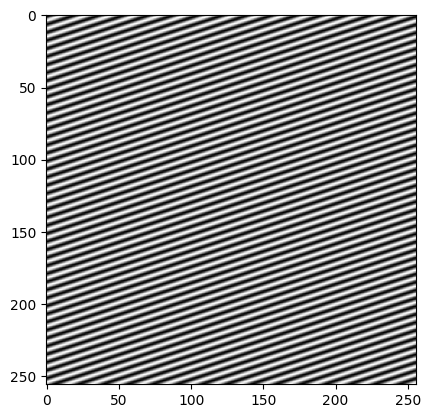

In [12]:
import matplotlib.pyplot as plt
import open3d as o3d
import glob
from pydicom import dcmread
import cv2
import math 
import copy
import pgzip

for index, fold in enumerate(dataset_folds):
    trainloader, valloader, trainset, testset = fold

    plt.imshow(np.mean(trainset[0][0].numpy()[0, 31:34], axis=0), cmap = "gray")
    plt.show()
    
    break

## Prepopulate the cache
Optionally, you can prepopulate the cache first before calling the training loop

In [13]:
from tqdm import tqdm

for fold in dataset_folds:
    trainloader, valloader, trainset, testset = fold
    
    for train_point in tqdm(trainset):
        pass
        break
    print("------------------")
    for val_point in tqdm(testset):
        pass
        break
    
    break

  0%|          | 0/2848 [00:04<?, ?it/s]


------------------


  0%|          | 0/357 [00:14<?, ?it/s]


# Model

In [14]:
import timm_3d
import torch.nn as nn
from spacecutter.losses import CumulativeLinkLoss
from spacecutter.models import LogisticCumulativeLink
from spacecutter.callbacks import AscensionCallback


class Classifier3dMultihead(nn.Module):
    def __init__(self,
                 backbone="efficientnet_lite0",
                 in_chans=1,
                 out_classes=5,
                 cutpoint_margin=0.15,
                 pretrained=False):
        super(Classifier3dMultihead, self).__init__()
        self.out_classes = out_classes

        self.backbone = timm_3d.create_model(
            backbone,
            features_only=False,
            drop_rate=CONFIG["drop_rate"],
            drop_path_rate=CONFIG["drop_path_rate"],
            pretrained=pretrained,
            in_chans=in_chans,
            global_pool="max",
        )
        if "efficientnet" in backbone:
            head_in_dim = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Sequential(
                nn.LayerNorm(head_in_dim),
                nn.Dropout(CONFIG["drop_rate_last"]),
            )

        elif "vit" in backbone:
            self.backbone.head.drop = nn.Dropout(p=CONFIG["drop_rate_last"])
            head_in_dim = self.backbone.head.fc.in_features
            self.backbone.head.fc = nn.Identity()

        self.heads = nn.ModuleList(
            [nn.Sequential(
                nn.Linear(head_in_dim, 1),
                LogisticCumulativeLink(CONFIG["out_dim"])
            ) for i in range(out_classes)]
        )

        self.ascension_callback = AscensionCallback(margin=cutpoint_margin)

    def forward(self, x):
        feat = self.backbone(x)
        return torch.swapaxes(torch.stack([head(feat) for head in self.heads]), 0, 1)

    def _ascension_callback(self):
        for head in self.heads:
            self.ascension_callback.clip(head[-1])

# Training

## Training util functions

In [15]:
import os.path

from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
import torch.nn as nn
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def model_validation_loss(model, val_loader, loss_fns, epoch):
    val_loss = 0
    unweighted_val_loss = 0
    alt_val_loss = 0
    unweighted_alt_val_loss = 0

    with torch.no_grad():
        model.eval()

        for images, label in tqdm(val_loader, desc=f"Validating epoch {epoch}"):
            label = label.to(device).unsqueeze(-1)

            with autocast(enabled=device != "cpu", dtype=torch.bfloat16):
                output = model(images.to(device))

                for index, loss_fn in enumerate(loss_fns["train"]):
                    if len(loss_fns["train"]) > 1:
                        loss = loss_fn(output[:, index], label[:, index]) / len(loss_fns["train"])
                    else:
                        loss = loss_fn(output, label) / len(loss_fns["train"])
                    val_loss += loss.cpu().item()

                for index, loss_fn in enumerate(loss_fns["unweighted_val"]):
                    if len(loss_fns["unweighted_val"]) > 1:
                        loss = loss_fn(output[:, index], label[:, index]) / len(loss_fns["unweighted_val"])
                    else:
                        loss = loss_fn(output, label) / len(loss_fns["unweighted_val"])
                    unweighted_val_loss += loss.cpu().item()

                for index, loss_fn in enumerate(loss_fns["alt_val"]):
                    if len(loss_fns["alt_val"]) > 1:
                        # !TODO: Label squeezed for CE loss
                        loss = loss_fn(output[:, index], label.squeeze(-1)[:, index]) / len(loss_fns["alt_val"])
                    else:
                        loss = loss_fn(output, label) / len(loss_fns["alt_val"])
                    alt_val_loss += loss.cpu().item()

                for index, loss_fn in enumerate(loss_fns["unweighted_alt_val"]):
                    if len(loss_fns["unweighted_alt_val"]) > 1:
                        # !TODO: Label squeezed for CE loss
                        loss = loss_fn(output[:, index], label.squeeze(-1)[:, index]) / len(
                            loss_fns["unweighted_alt_val"])
                    else:
                        loss = loss_fn(output, label) / len(loss_fns["alt_val"])
                    unweighted_alt_val_loss += loss.cpu().item()

                del output
            # torch.cuda.empty_cache()

        val_loss = val_loss / len(val_loader)
        unweighted_val_loss = unweighted_val_loss / len(val_loader)
        alt_val_loss = alt_val_loss / len(val_loader)
        unweighted_alt_val_loss = unweighted_alt_val_loss / len(val_loader)

        return val_loss, unweighted_val_loss, alt_val_loss, unweighted_alt_val_loss


def dump_plots_for_loss_and_acc(losses,
                                val_losses,
                                unweighted_val_losses,
                                alt_val_losses,
                                unweighted_alt_val_losses,
                                data_subset_label,
                                model_label):
    plt.plot(np.log(losses), label="train")
    plt.plot(np.log(val_losses), label="weighted_val")
    plt.plot(np.log(unweighted_val_losses), label="unweighted_val")
    plt.plot(np.log(alt_val_losses), label="alt_val")
    plt.plot(np.log(unweighted_alt_val_losses), label="unweighted_alt_val")
    plt.legend(loc="center right")
    plt.title(data_subset_label)
#     plt.savefig(f'./figures/{model_label}_loss.png')
#     plt.close()
    plt.show()

def train_model_with_validation(model,
                                optimizers,
                                schedulers,
                                loss_fns,
                                train_loader,
                                val_loader,
                                train_loader_desc=None,
                                model_desc="my_model",
                                gradient_accumulation_per=1,
                                epochs=10,
                                freeze_backbone_initial_epochs=0,
                                empty_cache_every_n_iterations=0,
                                loss_weights=None,
                                callbacks=None):
    epoch_losses = []
    epoch_validation_losses = []
    epoch_unweighted_validation_losses = []
    epoch_alt_validation_losses = []
    epoch_unweighted_alt_validation_losses = []

    scaler = GradScaler(init_scale=4096)

    if freeze_backbone_initial_epochs > 0:
        freeze_model_backbone(model)

    for epoch in tqdm(range(epochs), desc=train_loader_desc):
        epoch_loss = 0
        model.train()

        if freeze_backbone_initial_epochs > 0 and epoch == freeze_backbone_initial_epochs:
            unfreeze_model_backbone(model)

        for index, val in enumerate(tqdm(train_loader, desc=f"Epoch {epoch}")):
            images, label = val
            label = label.to(device).unsqueeze(-1)

            with autocast(enabled=device != "cpu", dtype=torch.bfloat16):
                output = model(images.to(device))

                del images

                if len(loss_fns["train"]) > 1:
                    loss = sum([(loss_fn(output[:, loss_index], label[:, loss_index]) / gradient_accumulation_per) for
                                loss_index, loss_fn in enumerate(loss_fns["train"])]) / len(loss_fns["train"])
                else:
                    loss = loss_fns["train"][0](output, label) / gradient_accumulation_per
                epoch_loss += loss.detach().cpu().item() * gradient_accumulation_per  # / len(loss_fns["train"])

                del label

            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1e9)

            del output

            # Per gradient accumulation batch or if the last iter
            if index % gradient_accumulation_per == 0 or index == len(train_loader) - 1:
                for optimizer in optimizers:
                    scaler.step(optimizer)
                    optimizer.zero_grad(set_to_none=True)
                scaler.update()

            if callbacks:
                for callback in callbacks:
                    callback()

            # prof.step()
            if empty_cache_every_n_iterations > 0 and index % empty_cache_every_n_iterations == 0:
                torch.cuda.empty_cache()

            while os.path.exists(".pause"):
                pass

        epoch_loss = epoch_loss / len(train_loader)
        epoch_validation_loss, epoch_unweighted_validation_loss, epoch_alt_validation_loss, epoch_unweighted_alt_validation_loss = (
            model_validation_loss(model, val_loader, loss_fns, epoch)
        )

        for scheduler in schedulers:
            scheduler.step()

        if (epoch % 5 == 0
            or len(epoch_validation_losses) == 0
            or epoch_validation_loss < min(epoch_validation_losses)) \
                or epoch_unweighted_validation_loss < min(epoch_unweighted_validation_losses) \
                or epoch_alt_validation_loss < min(epoch_alt_validation_losses):
            os.makedirs(f'/home/ai/neo/data/model/{model_desc}', exist_ok=True)
            torch.save(model.state_dict(),
                       # torch.jit.script(model),
                       f'/home/ai/neo/data/model/{model_desc}/{model_desc}' + "_" + str(epoch) + ".pt")

        epoch_validation_losses.append(epoch_validation_loss)
        epoch_unweighted_validation_losses.append(epoch_unweighted_validation_loss)
        epoch_alt_validation_losses.append(epoch_alt_validation_loss)
        epoch_unweighted_alt_validation_losses.append(epoch_unweighted_alt_validation_loss)

        epoch_losses.append(epoch_loss)

        dump_plots_for_loss_and_acc(epoch_losses,
                                    epoch_validation_losses,
                                    epoch_unweighted_validation_losses,
                                    epoch_alt_validation_losses,
                                    epoch_unweighted_alt_validation_losses,
                                    train_loader_desc, model_desc)
        print(f"Training Loss for epoch {epoch}: {epoch_loss:.6f}")
        print(f"Validation Loss for epoch {epoch}: {epoch_validation_loss:.6f}")
        print(f"Unweighted Validation Loss for epoch {epoch}: {epoch_unweighted_validation_loss:.6f}")
        print(f"Alt Validation Loss for epoch {epoch}: {epoch_alt_validation_loss:.6f}")
        print(f"Unweighted Alt Validation Loss for epoch {epoch}: {epoch_unweighted_alt_validation_loss:.6f}")

    return epoch_losses, epoch_validation_losses

## Loss Functions

In [16]:
schedulers = [
]
criteria = {
    "train": [
        CumulativeLinkLoss(class_weights=[1,2,4]) for i in range(CONFIG["num_classes"])
    ],
    "unweighted_val": [
        CumulativeLinkLoss() for i in range(CONFIG["num_classes"])
    ],
    "alt_val": [
        nn.CrossEntropyLoss(weight=torch.Tensor([1,2,4])).to(CONFIG["device"]) for i in range(CONFIG["num_classes"])
    ],
    "unweighted_alt_val": [
        nn.CrossEntropyLoss().to(device) for i in range(CONFIG["num_classes"])
    ]
}

## Putting it all together

In [17]:
# 获取可用GPU
device_ids = [i for i in range(torch.cuda.device_count())]

for index, fold in enumerate(dataset_folds):
    # !TODO: Remove me, I am here to save some GPU time
    if index > 0:
        break
    # model = Classifier3dMultihead(backbone=CONFIG["backbone"], in_chans=3, out_classes=CONFIG["num_classes"]).to(CONFIG["device"])
    model = Classifier3dMultihead(backbone=CONFIG["backbone"], in_chans=3, out_classes=CONFIG["num_classes"])
    model = torch.nn.DataParallel(model, device_ids=device_ids)
    model = model.to(device_ids[0])
    optimizers = [
        torch.optim.AdamW(model.parameters(), lr=3e-4),
    ]

    trainloader, valloader, trainset, testset = fold

    train_model_with_validation(model,
                                optimizers,
                                schedulers,
                                criteria,
                                trainloader,
                                valloader,
                                model_desc=CONFIG["backbone"] + f"_fold_{index}",
                                train_loader_desc=f"Training {CONFIG['backbone']} fold {index}",
                                epochs=CONFIG["epochs"],
                                freeze_backbone_initial_epochs=0,
                                # callbacks=[model._ascension_callback],
                                gradient_accumulation_per=CONFIG["gradient_acc_steps"]
                                )

/home/ai/anaconda3/envs/rsna/lib/python3.8/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/tmp/ipykernel_625178/2776218493.py:106: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(init_scale=4096)
Training maxvit_rmlp_tiny_rw_256 fold 0:   0%|          | 0/100 [00:00<?, ?it/s]